# Convolutional neural networks. Recognition of formation energies in alloys.


# Abstract

With the assistance of a convolutional neural network (CNN), we predict the formation energies of crystal structures belonging to the half-Heusler alloys with the formula (Nb$_x$Ta$_{1-x}$)$_{1-z}$Vac$_z$CoSb and (Nb$_x$V$_{1-x}$)$_{1-z}$Vac$_z$CoSb, where Vac is the % of vacancy defects. We first create atomic distribution using a combination of quantum mechanics and statistical physics [Miranda, Phys. Rev. B 101, 064201 (2020), Miranda and Gruhn, J. Mater. Chem. A, 2021,9, 21111]. The labeled energy images of these atomic distributions at different compositions and temperatures are fed into the CNN.

We also model throughout the training in parallel with a CNN and NN, the addition of extra information to the images, and the values of temperature and/or atomic composition. In a final model, we use input images and temperature and try to predict the energy and composition.

# Introduction

In our previous studies of Half-heusler alloy, we applied a multi-scale method to study atomic distributions in (Nb$_x$V$_{1-x}$)$_{1-z}$Vac$_z$CoSb where we linked quantum mechanical (density function theory, DFT) and statistical (Monte Carlo sampling) calculations by an atomic cluster expansion. Here we showed that there is a complex arrangement of Nb and V atoms that could be key to manipulating thermal conductivity without strongly deteriorating the electric transport, both types of conductions are crucial to obtaining a high figure of merit (ZT). 

In this work, we generate a total of 4321 images of atomic distributions by the Monte Carlo method. For all images, we have information about their formation energy at given alloy compositions and temperatures. We use the energy as labeled data to train a CNN to predict these energies of formation or the energy and temperature to predict the energy of formation and composition.

To ilustrate the chemical information we capture in a simulation, we display the electron charge density obtained for one DFT calculation in V$_0.8$Vac$_{0.2}$CoSb which is used to obtain effective parameters for the Monte Carlo simulations. In all figures we use as color code Nb:yellow, V:Green, Ta:Light blue, Co: Brown, Sb: Dark blue, and Vacancies: Magenta

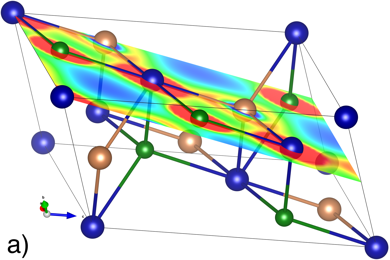

In [2]:
from PIL import Image
size = 390, 260
im = Image.open("fig6a.png")
im = im.resize(size)
im

The next figure shows one MC snapshots containing 157216 active lattice sites for the composition  Nb$_{0.64}$V$_{0.16}$Vac$_{0.8}$CoSb at 400 K. Here we can see the type of local and short range ordering the convolutional neural network should be able to understand. The Co and Sb are not displayed, since they are not allowed to drift in out models.

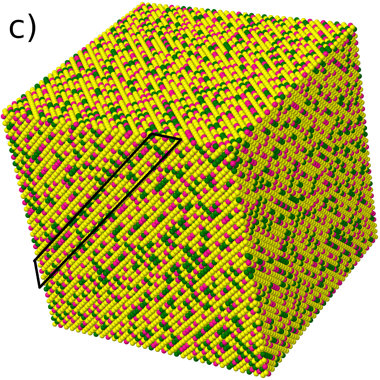

In [9]:
size = 380, 380
im = Image.open("fig10c.png")
im = im.resize(size)
im

The image we provide to the CNN are cross section of the six facades of each cube at a given temperature and alloy composition. In addition, we rotate 180 each image to augment our dataset. We prape two sets of images with 255x255 pixels and 510x510 pixels.

An interesting observation is that vacancies prefer to be located at the Nb-rich phase, as the next figure shows.

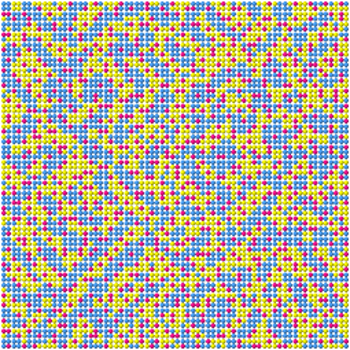

In [11]:
size = 350, 350
im = Image.open("300_0.20_0.40_0_-0.489636_.png")
im = im.resize(size)
im

The next two images correspond to the compositions Nb$_{0.40}$Ta$_{0.40}$Vac$_{0.8}$CoSb and Nb$_{0.16}$Ta$_{0.64}$Vac$_{0.8}$CoSb at 300 K. In the practice, atom imaging does not see directly vacacnies, therefore, we have removed them

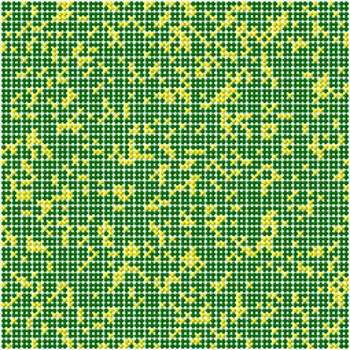

In [12]:
im = Image.open("300_0.20_0.16_0_-0.155551_nbv_.png")
im = im.resize(size)
im

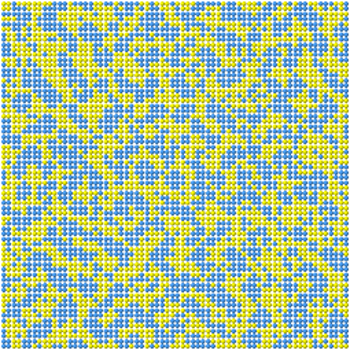

In [13]:
im = Image.open("300_0.20_0.40_1_-0.489636_.png")
im = im.resize(size)
im

The temperture dependent energy of Nb$_{0.40}$Ta$_{0.40}$Vac$_{0.8}$CoSb and Nb$_{0.16}$Ta$_{0.64}$Vac$_{0.8}$CoSb and Nb$_{0.16}$V$_{0.64}$Vac$_{0.8}$CoSb is displayed. These are the energy we label for our images and which we use to train our CNN models.

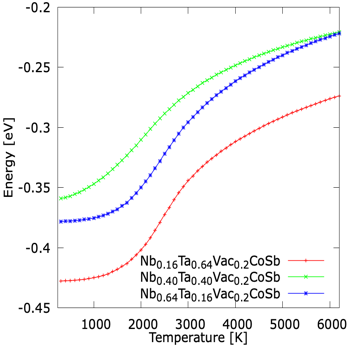

In [14]:
im = Image.open("all.png")
im = im.resize(size)
im

# Programs

We address the problem by first creating three CNN models for each individual set of data with formula  Nb$_{0.40}$Ta$_{0.40}$Vac$_{0.8}$CoSb and Nb$_{0.16}$Ta$_{0.64}$Vac$_{0.8}$CoSb and Nb$_{0.16}$V$_{0.64}$Vac$_{0.8}$CoSb. Then, we create a single CNN model to identify all three concentrations in a single model. This is presented in the slide convol_NN_NbTaVavCoSb.pdf.

For the general case of identifying simultaneously the formation energies of the two types of alloys (Nb$_x$Ta$_{1-x}$)$_{1-z}$Vac$_z$CoSb and (Nb$_x$V$_{1-x}$)$_{1-z}$Vac$_z$CoSb, which is in this Jupyten book reviewed.

# Load modules

In [ ]:
import os
# import re
# import glob
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import img_to_array

# Preprocessing

In [ ]:
################# Preprocessing Images ################3
####### Remove white edges and Jmol logo  ###########
file_src0="snapshots_trimmed/"
for x in os.listdir(file_src0):
    img = Image.open(os.path.join(file_src0, x))
    cropped = img.crop((9.5, 9.5, 264.75, 264.75))  
    cropped.save(os.path.join(file_src0, x))

In [ ]:
# ######### rotate 180 grades  $##############
# Double the amount of data by rotating 180 every snapshot
file_src2="snapshots_trimmed"
file_src3="snapshots_rotate180"
for x in os.listdir(file_src2):
    img = Image.open(os.path.join(file_src2, x))
    rotate_img = img.rotate(180)  
    rotate_img.save(os.path.join(file_src3, x))

In [ ]:
# Auxiliary arrays for saving images, compostion, temperature and energy

snaps = []          # list with images
temperatures = []   # list temperatures
y = []              # list energies eV

In [ ]:
# The folder snapshots contains the images, the name of each file provides information
# with temperature, stress.

file_src="snapshots/"
for x in os.listdir(file_src):
#        print(os.path.basename(x))
        energy =' _'.join(x.split('_')[4:5])
        temper = ' _'.join(x.split('_')[0:1])
        y.append(float(energy))
        temperatures.append(float(temper))
        snap = iio.imread(file_src + x)
        snaps.append(snap)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(snaps[i])
    plt.axis('off')
    pair = (temperatures[i], y[i] )
    plt.title(pair, fontdict={'size': 8})
plt.show()

In [ ]:
# Convert lists into numpy arrays for correct processing data. Labeled data is y 
# and features X. The images have 255x255 pixels size. 
# Remove afterwards the lists.

X = np.array(snaps)
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.50,
                                                    random_state=42)

del snaps

# Modelling

In [ ]:
# Start modelling

model = keras.models.Sequential()

########### Modeling using predeterminated Netzwerk   ##############

# MobileNet V1
base_model = keras.applications.MobileNet(
    input_shape=(255, 255, 3),
    alpha=1,              # Anzahl der Kanäle um einen Faktor verringern
    depth_multiplier=1,     # Anzahl der Schichten um einen Faktor vergrößern
    dropout=0.001,          # Dropout vor der Ausgabeschicht
    include_top=False,       # Wir wollen die Ausgabeschicht entfernen
    weights="imagenet",      # Entweder von 'imagenet' oder None
    input_tensor=None,       # Kann als Eingabe in das Modell verwendet werden
    pooling='avg',            # Wenn include_top=False kann eine Pooling-Schicht hinzugefügt werden
    # Wenn include_top=True, und weights=None, dann kann die Anzahl der Ausgabeneuronen eingestellt werden
    classes=1000,
    classifier_activation="softmax")  # Nur wenn include_top=True

base_model.summary()

In [ ]:
###########  Output layers   ###########
model.add(base_model)
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))  

model.summary()

In [ ]:
# We define our own score

def r2_score(y_true, y_pred):
    y_diff = tf.reduce_sum(tf.square(y_true-y_pred))
    y_square = tf.reduce_sum(tf.square(y_true-tf.reduce_mean(y_true)))
    return 1-y_diff/y_square

# Define loss function, optimizer and metri
model.compile(loss='mse', optimizer='adam', metrics=r2_score)

base_model.trainable = False
model.summary()

history = model.fit(X_train, y_train, epochs=94, batch_size=12,
                    validation_data=(X_test, y_test))

model.save('p255_MobiNetD4_batch12_5200-300_m5050_epoch94.h5')

# Plotting results

In [ ]:
# Lernkurven darstellen
plt.plot(history.history['r2_score'], label='Train data')
plt.plot(history.history['val_r2_score'], label='Test data')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.xlim(0,94)
plt.ylim(-0.5,1)
plt.legend()
plt.title("p255_MobiNetD4_batch12_5200-300_m5050_epoch94")
plt.tight_layout()
plt.savefig('p255_MobiNetD4_batch12_5200-300_m5050_epoch94b.png')
plt.show()

# Loss-funkion darstellen
plt.plot(history.history['loss'], label='Train data')
plt.plot(history.history['val_loss'], label='Test data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0,94)
#plt.ylim(0.,0.21)
plt.legend()
plt.title("p255_MobiNetD4_batch12_300_m5050")
plt.tight_layout()
plt.savefig('p255_MobiNetD4_batch12_300_m5050_loss_Epoch94b.png')
plt.show()

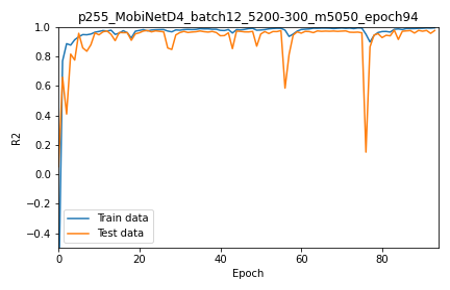

In [4]:
size = 450, 290
im = Image.open("p255_MobiNetD4_batch12_5200-300_m5050_epoch94.png")
im = im.resize(size)
im

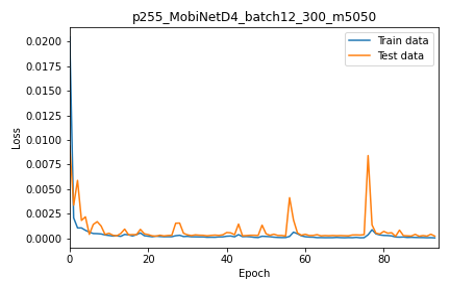

In [5]:
im = Image.open("p255_MobiNetD4_batch12_300_m5050_loss_Epoch94.png")
im = im.resize(size)
im

# Conclusions